<a href="https://colab.research.google.com/github/ryanleeallred/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

#### How is a confidence interval built, and how should it be interpreted?

It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is: 

> "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


---
---

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Get the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-17 19:51:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-09-17 19:51:36 (312 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [4]:
# Load data in dataframe and add in column headers
df = pd.read_csv("house-votes-84.data",
                   header=None,
                   names=["party", "handicapped-infants", "water-project",
                         "budget", "physician-fee-freeze", "el-salvador-aid",
                         "religious-groups", "anti-satellite-ban",
                         "aid-to-contras", "mx-missile", "immigration",
                         "synfuels", "education", "right-to-sue", "crime",
                         "duty-free", "south-africa"])

print(df.shape)
df.head(2)

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?


In [6]:
# Replace "?" with NaN and "y" / "n" with 1 / 0 
df = df.replace({
    "?": np.NaN,
    "n": 0,
    "y": 1,
})

print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


#### 1. Generate and numerically represent a confidence interval

In [21]:
def confidence_interval(data, confidence=0.95):
    """
    Calculates a confidence interval around a sample mean for given data,
    using t-distribution and two-tailed test, default 95% confidence. 

    Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval

    Returns:
    tuple of (mean, lower bound, upper bound)
    """
    data = np.array(data)  # Standardize to numpy array
    mean = np.mean(data)
    n = len(data)
    
    # Stdev divided by sqare root of n (degrees of freedom / # observations)
    stderr = np.std(data, ddof=1) / np.sqrt(n)
    
    # Std error multiplied by t-statistic gives margin of error
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    print(f"Margin of error: {margin_of_error}")
    print(f"Mean: {mean}")
    print(f"Lower bound: {mean - margin_of_error}")
    print(f"Upper bound: {mean + margin_of_error}")

    return (mean, mean - margin_of_error, mean + margin_of_error)

In [24]:
# Confidence interval of votes on the "immigration" bill
immigration = df["immigration"].dropna(how="any")
ci = confidence_interval(immigration)  # Drop null values from the column before using it in calculations
ci

Margin of error: 0.04755737973054505
Mean: 0.5046728971962616
Lower bound: 0.45711551746571655
Upper bound: 0.5522302769268067


(0.5046728971962616, 0.45711551746571655, 0.5522302769268067)

In [29]:
# Count number of votes for and against
df["immigration"].value_counts()

1.0    216
0.0    212
Name: immigration, dtype: int64

In [30]:
# Look at the votes for and against per party
df["immigration"].groupby(df["party"]).value_counts()

party       immigration
democrat    0.0            139
            1.0            124
republican  1.0             92
            0.0             73
Name: immigration, dtype: int64

---

#### 2. Graphically (with a plot) represent the confidence interval

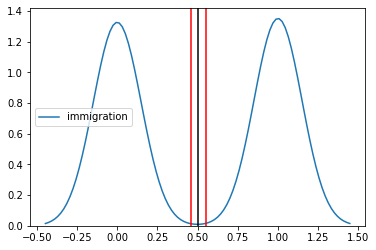

In [25]:
# Plot with seaborn kdeplot
sns.kdeplot(immigration)

# Add lines to represent the confidence interval bounds
plt.axvline(x=ci[1], color="r");
plt.axvline(x=ci[2], color="r");
plt.axvline(x=ci[0], color="k");

---

#### 3. Interpret the confidence interval — what does it tell you about the data and its distribution?

The sample mean falls almost squarely in the middle of the confidence interval. Therefore we will fail to reject the null hypothesis that the sample mean significantly favors a vote for or against the bill.

The fact that the mean is almost exactly 0.5 means that the vote distribution was almost equally "for" and "against" the immigration bill.

---

#### 4. Take a dataset that we've used in the past in class that has **categorical** variables. Pick two of those categorical variables and run chi-squared tests on that data

##### $\chi^2$ test by hand using NumPy

##### $\chi^2$ one-liner using SciPy

---
---

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)